In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('AB_NYC_2019.csv')

## EDA

<AxesSubplot:xlabel='price', ylabel='Count'>

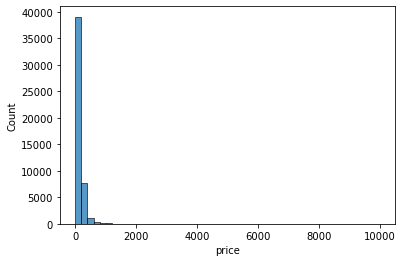

In [3]:
sns.histplot(df.price,bins=50)

In [4]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [5]:
df =df.drop(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood','room_type','last_review'],axis=1)

In [6]:
df

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,40.64749,-73.97237,149,1,9,0.21,6,365
1,40.75362,-73.98377,225,1,45,0.38,2,355
2,40.80902,-73.94190,150,3,0,NaN,1,365
3,40.68514,-73.95976,89,1,270,4.64,1,194
4,40.79851,-73.94399,80,10,9,0.10,1,0
...,...,...,...,...,...,...,...,...
48890,40.67853,-73.94995,70,2,0,NaN,2,9
48891,40.70184,-73.93317,40,4,0,NaN,2,36
48892,40.81475,-73.94867,115,10,0,NaN,1,27
48893,40.75751,-73.99112,55,1,0,NaN,6,2


### Question 1
Find a feature with missing values.

In [7]:
df.isnull().sum()

latitude                              0
longitude                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

`reviews_per_month` =10052

### Question 2

What's the median (50% percentile) for variable 'minimum_nights'?

In [8]:
df.minimum_nights.median()

3.0

### Question 3

- We need to deal with missing values for the column from Q1.
- We have two options: fill it with 0 or with the mean of this variable.
- Try both options. For each, train a linear regression model without regularization using the code from the lessons.
- For computing the mean, use the training only!
- Use the validation dataset to evaluate the models and compare the RMSE of each option.
- Round the RMSE scores to 2 decimal digits using round(score, 2)
-  Which option gives better RMSE?


In [9]:
def dot(xi,w):
    n = len(xi)
    
    res= 0.0
    
    for j in range(n):
        res = res + xi[j]*w[j]
        
    return res

In [33]:
def train_linear_regression(X,y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones,X])
    
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0],w[1:]

## Dataset Preparation

In [11]:
n = len(df)

n_val = int(0.2*n)
n_test = int(0.2*n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

In [12]:
df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [13]:
y_train_orig = df_train.price.values
y_val_orig = df_val.price.values
y_test_orig = df_test.price.values

y_train = np.log1p(y_train_orig)
y_val = np.log1p(y_val_orig)
y_test =  np.log1p(y_test_orig)

In [14]:
del df_train['price']
del df_val['price']
del df_test['price']

In [15]:
df_train.columns

Index(['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [16]:
check = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365']

def prepare_X(df, fillna_value):
    df_num=df[check]
    df_num = df_num.fillna(fillna_value)
    X = df_num.values
    return X

In [17]:
def rmse(y,y_pred):
    error = y_pred - y
    mse = (error**2).mean()
    return np.sqrt(mse)

In [18]:
mean = df_train.reviews_per_month.mean()

X_mean_train = prepare_X(df_train , fillna_value=mean)
w_0_mean,w_mean = train_linear_regression(X_mean_train,y_train)

In [19]:
X_mean_val = prepare_X(df_val,fillna_value=mean)
y_mean_pred_val = w_0_mean + X_mean_val.dot(w_mean)

In [20]:
np.round(rmse(y_val,y_mean_pred_val),2)

0.64

In [21]:
X_null_train = prepare_X(df_train , fillna_value=0)
w_0_null , w_null = train_linear_regression(X_null_train , y_train)

In [22]:
X_null_val = prepare_X(df_val , fillna_value=0)
y_null_pred_val = w_0_null + X_null_val.dot(w_null)

In [23]:
np.round(rmse(y_val,y_null_pred_val),2)

0.64

## Answer: Both are equal


### Question 4

-    Now let's train a regularized linear regression.
-    For this question, fill the NAs with 0.
-    Try different values of r from this list: [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10].
-    Use RMSE to evaluate the model on the validation dataset.
-    Round the RMSE scores to 2 decimal digits.
-    Which r gives the best RMSE?If there are multiple options, select the smallest r.

In [29]:
def train_linear_regression_reg(X , y , r=0.0):
    ones =np.ones(X.shape[0])
    X = np.column_stack([ones,X])
    
    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg
    
    XTX_inv =np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0],w[1:]

In [32]:
for r in [0,0.000001,0.001,0.1,1,5,10]:
    w_0 , w = train_linear_regression_reg(X_null_train,y_train, r=r)
    y_null_reg_val = w_0 +X_null_val.dot(w)
    rmse_val = np.round(rmse(y_val,y_null_reg_val),2)
    print(r,w_0,rmse_val)

0 -419.91265863459563 0.64
1e-06 -419.86271586621507 0.64
0.001 -375.27365275360376 0.64
0.1 -32.56256054996282 0.68
1 -3.4992168360568994 0.68
5 -0.7033623167239721 0.68
10 -0.3512767588949242 0.68


### Question 5

-    We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
-    Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
-    For each seed, do the train/validation/test split with 60%/20%/20% distribution.
-    Fill the missing values with 0 and train a model without regularization.
-    For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
-    What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
-    Round the result to 3 decimal digits (round(std, 3))


In [36]:
rmse_list = []

for r in [0,1,2,3,4,5,6,7,8,9]:
    idx =np.arange(n)
    np.random.seed(r)
    np.random.shuffle(idx)
    
    df_shuffled = df.iloc[idx]
    
    df_train  = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()
    
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    y_train_orig = df_train.price.values
    y_val_orig = df_val.price.values
    y_test_orig = df_test.price.values
    
    y_train = np.log1p(y_train_orig)
    y_val = np.log1p(y_val_orig)
    y_test = np.log1p(y_test_orig)
    
    del df_train['price']
    del df_val['price']
    del df_test['price']
    
    X_null_train = prepare_X(df_train,fillna_value=0)
    w_0 , w = train_linear_regression(X_null_train,y_train)
    
    X_null_val = prepare_X(df_val, fillna_value=0)
    y_null_reg_val = w_0 + X_null_val.dot(w)
    rmse_val = np.round(rmse(y_val,y_null_reg_val),2)
    
    rmse_list.append(rmse_val)
    
    print(r , w_0, rmse_val)

0 -427.62844626626065 0.65
1 -414.70554910891815 0.65
2 -423.25413365944166 0.65
3 -421.8933158935208 0.64
4 -422.0609909896383 0.64
5 -429.178752317333 0.63
6 -427.4918955501337 0.63
7 -428.18846990339546 0.65
8 -427.69291185977454 0.65
9 -426.9826895634907 0.64


In [38]:
rmse_list

[0.65, 0.65, 0.65, 0.64, 0.64, 0.63, 0.63, 0.65, 0.65, 0.64]

In [39]:
np.round(np.std(rmse_list),3)

0.008

### Question 6

-    Split the dataset like previously, use seed 9.
-    Combine train and validation datasets.
-    Fill the missing values with 0 and train a model with r=0.001.
-    What's the RMSE on the test dataset?


In [52]:
r = 9

idx = np.arange(n)
np.random.seed(r)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]
    
df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

frames = [df_train, df_val]
df_train_val = pd.concat(frames)

df_train_val = df_train_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train_val_orig = df_train_val.price.values
y_test_orig = df_test.price.values

y_train_val = np.log1p(y_train_val_orig)
y_test = np.log1p(y_test_orig)

del df_train_val['price']
del df_test['price']

In [53]:
X_null_train_val = prepare_X(df_train_val, fillna_value=0)
w_0_train_val, w_train_val = train_linear_regression_reg(X_null_train_val, y_train_val, r=0.001)

X_null_test = prepare_X(df_test, fillna_value=0)
y_null_pred_test = w_0_train_val + X_null_test.dot(w_train_val)

np.round(rmse(y_test, y_null_pred_test),2)

0.65